In [1]:
!pip install -qU torch_snippets

In [2]:
from torch_snippets import *
from PIL import Image
import cv2
import numpy as np
import torch
import torchvision
from torch.utils.data import Dataset, DataLoader
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.ops import nms
import pandas as pd
import glob
from sklearn.model_selection import train_test_split


/home/vitor/.local/lib/python3.10/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "


In [3]:
IMG_ROOT = '/home/vitor/Downloads/archive/data/training_images'
df = pd.read_csv('/home/vitor/Downloads/archive/data/train_solution_bounding_boxes.csv')
df = df.rename(columns={'image' : 'ImageID'})
df.head()

,ImageID,xmin,ymin,xmax,ymax
0,vid_4_1000.jpg,281.259045,187.035071,327.727931,223.225547
1,vid_4_10000.jpg,15.163531,187.035071,120.329957,236.430180
2,vid_4_10040.jpg,239.192475,176.764801,361.968162,236.430180
3,vid_4_10020.jpg,496.483358,172.363256,630.020260,231.539575
4,vid_4_10060.jpg,16.630970,186.546010,132.558611,238.386422


In [4]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

Using cuda device


In [5]:
#Spliting the data
trn_ids, val_ids = train_test_split(df['ImageID'].unique(), test_size=0.1, random_state=42)
trn_df = df[df['ImageID'].isin(trn_ids)]
val_df = df[df['ImageID'].isin(val_ids)]

In [6]:
label2target = {
    'background': 0,
    'car': 1
}

target2label = {t: l for l, t in label2target.items()}

background_class = label2target['background']
num_classes = len(label2target)

In [7]:
def preprocess_image(img):
    img = torch.tensor(img).permute(2,0,1)
    return img.to(device).float()

In [8]:
class OpenDataset(Dataset):
    def __init__(self, df, image_dir):
        self.w, self.h = 224, 224
        self.image_dir = image_dir
        self.files = glob.glob(f'{self.image_dir}/*')
        self.df = df.copy()
        self.image_infos = df['ImageID'].unique()

    def __len__(self):
        return len(self.image_infos)
        
    def __getitem__(self, ix):
        # Load image and corresponding annotations
        image_id = self.image_infos[ix]
        img_path = find(image_id, self.files)
        img = Image.open(img_path).convert("RGB")

        data = self.df[self.df['ImageID'] == image_id]
        H, W, _ = np.array(img).shape
        data.loc[:, ['xmin', 'ymin', 'xmax', 'ymax']] /= [W, H, W, H]

        img = np.array(img.resize((self.w, self.h), resample=Image.Resampling.BILINEAR)) / 255.0

        labels = ['car'] * len(data)
        data = data[['xmin', 'ymin', 'xmax', 'ymax']].values
        data[:, [0, 2]] *= self.w
        data[:, [1, 3]] *= self.h
        boxes = data.astype(np.uint32).tolist()

        target = {
            "boxes": torch.Tensor(boxes).float(),
            "labels": torch.Tensor([label2target[i] for i in labels]).long()
        }

        img = preprocess_image(img)
        return img, target
        
    def collate_fn(self, batch):
        return tuple(zip(*batch))

In [9]:
train_ds = OpenDataset(trn_df, IMG_ROOT)
test_ds = OpenDataset(val_df, IMG_ROOT)

# Create the data loaders
train_loader = DataLoader(
    train_ds,
    batch_size=4,
    collate_fn=train_ds.collate_fn,
    drop_last=True
)

test_loader = DataLoader(
    test_ds,
    batch_size=4,
    collate_fn=test_ds.collate_fn,
    drop_last=True
)

# Print to verify the DataLoader creation
print(f"Train DataLoader: {len(train_loader)} batches")
print(f"Test DataLoader: {len(test_loader)} batches")

Train DataLoader: 79 batches
Test DataLoader: 9 batches


In [10]:
import certifi
import ssl
import torchvision

ssl._create_default_https_context = ssl._create_unverified_context
# Alternatively, you can specify the certifi path:
# ssl._create_default_https_context = lambda: ssl.create_default_context(cafile=certifi.where())

def get_model():
    #Load a pre-trained Faster R-CNN model with a ResNet-50 backbone and replace the
    #box predictor to match the number of classes in the current dataset.
    
    #Returns: model (torchvision.models.detection.FasterRCNN): The modified Faster R-CNN model.
    
    # Load the pre-trained Faster R-CNN model
    model = torchvision.models.detection.fasterrcnn_resnet50_fpn(weights=True)
    
    in_features = model.roi_heads.box_predictor.cls_score.in_features

    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
    
    return model

In [11]:
def train_batch(inputs, model, optimizer):
    #Train the model on a single batch of inputs.

    model.train()
    input_images, targets = inputs

    input_images = [image.to(device) for image in input_images]
    targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

    optimizer.zero_grad()

    losses = model(input_images, targets)

    loss = sum(loss for loss in losses.values())

    loss.backward()
    optimizer.step()

    return loss, losses

@torch.no_grad() 
def validate_batch(inputs, model):
    
    model.train()  
    input_images, targets = inputs

    input_images = [image.to(device) for image in input_images]
    targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

    optimizer.zero_grad()

    # Forward pass
    losses = model(input_images, targets)

    # Compute total loss
    loss = sum(loss for loss in losses.values())

    return loss, losses

In [12]:
model = get_model().to(device)

optimizer = torch.optim.SGD(
    model.parameters(),
    lr=0.005,
    momentum=0.9,
    weight_decay=0.0005
)

n_epochs = 10

log = Report(n_epochs)

print(f"Model initialized and moved to {device}")
print(f"Optimizer: {optimizer}")
print(f"Number of epochs: {n_epochs}")
print("Logging/reporting mechanism initialized")


/home/vitor/.local/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FasterRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Model initialized and moved to cuda
Optimizer: SGD (
Parameter Group 0
    dampening: 0
    differentiable: False
    foreach: None
    fused: None
    lr: 0.005
    maximize: False
    momentum: 0.9
    nesterov: False
    weight_decay: 0.0005
)
Number of epochs: 10
Logging/reporting mechanism initialized


In [13]:
for epoch in range(n_epochs):
    
    _n = len(train_loader)
    for ix, inputs in enumerate(train_loader):
        
        loss, losses = train_batch(inputs, model, optimizer)
    
        loc_loss, regr_loss, loss_objectness, loss_rpn_box_reg = (
            losses[k] for k in ['loss_classifier', 'loss_box_reg', 'loss_objectness', 'loss_rpn_box_reg']
        )

        pos = epoch + (ix + 1) / _n
        
        log.record(
            pos,
            trn_loss=loss.item(),
            trn_loc_loss=loc_loss.item(),
            trn_regr_loss=regr_loss.item(),
            trn_objectness_loss=loss_objectness.item(),
            trn_rpn_box_reg_loss=loss_rpn_box_reg.item(),
            end='\r'
        )

    _n = len(test_loader)
    for ix, inputs in enumerate(test_loader):
        
        loss, losses = validate_batch(inputs, model)
        
        loc_loss, regr_loss, loss_objectness, loss_rpn_box_reg = (
            losses[k] for k in ['loss_classifier', 'loss_box_reg', 'loss_objectness', 'loss_rpn_box_reg']
        )
        
        pos = epoch + (ix + 1) / _n

        log.record(
            pos,
            val_loss=loss.item(),
            val_loc_loss=loc_loss.item(),
            val_regr_loss=regr_loss.item(),
            val_objectness_loss=loss_objectness.item(),
            val_rpn_box_reg_loss=loss_rpn_box_reg.item(),
            end='\r'
        )
    
    if (epoch + 1) % (n_epochs // 5) == 0:
        log.report_avgs(epoch + 1)

EPOCH: 2.000  trn_loss: 0.145  trn_loc_loss: 0.035  val_loc_loss: 0.040  trn_rpn_box_reg_loss: 0.002  val_objectness_loss: 0.001  trn_objectness_loss: 0.001  trn_regr_loss: 0.107  val_loss: 0.167  val_rpn_box_reg_loss: 0.002  val_regr_loss: 0.124  (133.04s - 532.16s remaining)
EPOCH: 4.000  trn_loss: 0.111  trn_loc_loss: 0.028  val_loc_loss: 0.042  trn_rpn_box_reg_loss: 0.001  val_objectness_loss: 0.001  trn_objectness_loss: 0.000  trn_regr_loss: 0.081  val_loss: 0.179  val_rpn_box_reg_loss: 0.002  val_regr_loss: 0.135  (263.97s - 395.95s remaining)
EPOCH: 6.000  trn_loss: 0.092  trn_loc_loss: 0.024  val_loc_loss: 0.042  trn_rpn_box_reg_loss: 0.001  val_objectness_loss: 0.001  trn_objectness_loss: 0.000  trn_regr_loss: 0.066  val_loss: 0.168  val_rpn_box_reg_loss: 0.003  val_regr_loss: 0.123  (394.63s - 263.09s remaining)
EPOCH: 8.000  trn_loss: 0.103  trn_loc_loss: 0.025  val_loc_loss: 0.040  trn_rpn_box_reg_loss: 0.001  val_objectness_loss: 0.001  trn_objectness_loss: 0.000  trn_regr

In [14]:
def decode_output(output):

    bbs = output['boxes'].cpu().detach().numpy().astype(np.uint16)
    labels = np.array([target2label[i] for i in output['labels'].cpu().detach().numpy()])
    confs = output['scores'].cpu().detach().numpy()

    ixs = nms(torch.tensor(bbs.astype(np.float32)), torch.tensor(confs), 0.05)

    bbs, confs, labels = [tensor[ixs] for tensor in [bbs, confs, labels]]

    if len(ixs) == 1:
        bbs, confs, labels = [np.array([tensor]) for tensor in [bbs, confs, labels]]

    return bbs.tolist(), confs.tolist(), labels.tolist()


|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      | 349116 KiB |   2772 MiB |  18404 GiB |  18404 GiB |
|       from large pool | 306360 KiB |   2732 MiB |  18309 GiB |  18308 GiB |
|       from small pool |  42756 KiB |     75 MiB |     95 GiB |     95 GiB |
|---------------------------------------------------------------------------|
| Active memory         | 349116 KiB |   2772 MiB |  18404 GiB |  18404 GiB |
|       from large pool | 306360 KiB |   2732 MiB |  18309 GiB |

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..255.0].


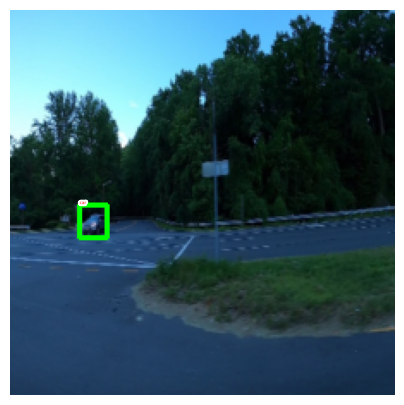

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..255.0].


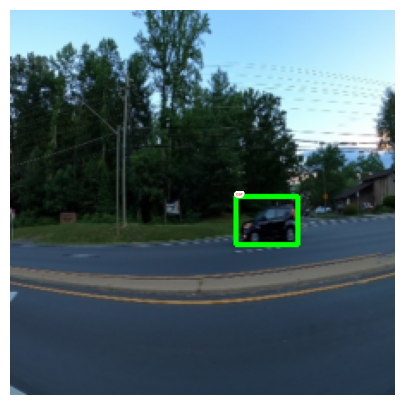

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..255.0].


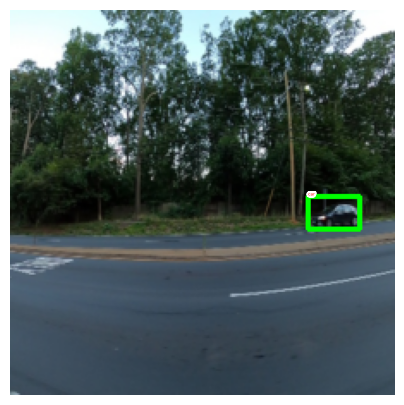

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..255.0].


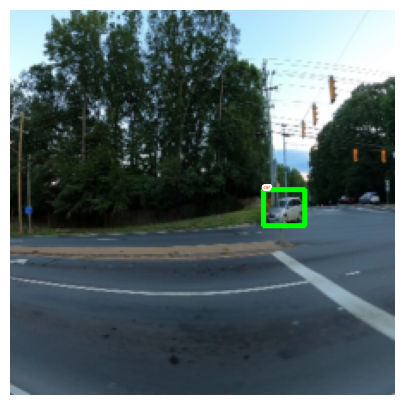

In [15]:
model.eval()

for batch_idx, (images, targets) in enumerate(test_loader):

    print(torch.cuda.memory_summary(device=None, abbreviated=False))

    if batch_idx == 3:
        break

    images = [im for im in images]

    outputs = model(images)

    for image_idx, output in enumerate(outputs):
        bbs, confs, labels = decode_output(output)
        info = [f'{l}@{c:.2f}' for l, c in zip(labels, confs)]

        show(images[image_idx].cpu().permute(1, 2, 0), bbs=bbs, texts=labels, sz=5)

    break
